In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import mudata
import anndata
import scanpy as sc
import pandas as pd
import numpy as np

from typing import List, Dict, Union

In [3]:
def sample_dataset():
    adata = sc.datasets.pbmc3k_processed()
    # adata2 = sc.datasets.blobs(n_observations=10000, n_centers=12, n_variables=500)
    ## Make DataFrame assigning cells to views
    assign_dict = {
        'myeloid':['CD14+ Monocytes', 'FCGR3A+ Monocytes', 'Dendritic cells', 'Megakaryocytes'],
        'lymphoid':['NK cells', "CD8 T cells", 'CD4 T cells', 'B cells'],
        'NKT cells':['NK cells', "CD8 T cells", 'CD4 T cells'],
        'T cells':["CD8 T cells", 'CD4 T cells'],
        'B cells':['B cells']
    }
    annotation_col = 'louvain'

    assign_tab = np.vstack([np.where(adata.obs[annotation_col].isin(assign_dict[k]), 1, 0) for k in assign_dict.keys()]).T
    assign_tab = pd.DataFrame(assign_tab, columns = assign_dict.keys(), index = adata.obs_names)

    ## Make dictionary of parent-child structure of views
    view_hierarchy = {
        'myeloid':None,
        'lymphoid':{
            "NKT cells":{
                'T cells':None
            },
            "B cells":None}
    }
    return(adata)


# ## small tests
# broken_assign_tab = assign_tab.copy()
# broken_assign_tab['T cells'] = broken_assign_tab['T cells'].sample(frac=1).values
# _clean_view_assingment(broken_assign_tab, view_hierarchy)

# assign_tab['ciaone'] = broken_assign_tab['T cells'].sample(frac=1).values
# _clean_view_assingment(assign_tab, view_hierarchy)

In [4]:
import multi_view_atlas as mva

In [236]:
adata = mva.utils.sample_dataset()
mvatlas = mva.tl.MultiViewAtlas(adata)
mvatlas
    # [np.where(np.array(s.split('.')) == v)[0][0]  if v in s]

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/mudata/_core/mudata.py:569: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/mudata/_core/mudata.py:569: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


MultiViewAtlas object with view hierarchy:
	lymphoid:
	  B cells: null
	  NKT cells:
	    T cells: null
	myeloid: null
	
MuData object with n_obs × n_vars = 2638 × 1838
  obsm:	'view_assign'
  6 modalities
    full:	2638 x 1838
      obs:	'n_genes', 'percent_mito', 'n_counts', 'louvain'
      var:	'n_cells'
      uns:	'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups', 'view_hierarchy'
      obsm:	'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr', 'view_assign'
      varm:	'PCs'
      obsp:	'distances', 'connectivities'
    myeloid:	682 x 0
      obs:	'n_genes', 'percent_mito', 'n_counts', 'louvain'
      obsm:	'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr', 'view_assign'
    lymphoid:	1956 x 0
      obs:	'n_genes', 'percent_mito', 'n_counts', 'louvain'
      obsm:	'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr', 'view_assign'
    NKT cells:	1614 x 0
      obs:	'n_genes', 'percent_mito', 'n_counts', 'louvain'
      obsm:	'X_pca', 'X_tsne', 'X_umap', 'X_draw_

In [237]:
mvatlas.views

['myeloid', 'lymphoid', 'NKT cells', 'T cells', 'B cells']

In [ ]:
## Re-compute embedding on each view
for v in mvatlas.views:
    vadata = mvatlas[v]
    sc.pp.pca(vadata)
    sc.pp.neighbors(vadata, n_neighbors=10)
    sc.tl.umap(vadata)
    mvatlas.mdata[v].obsm = vadata.obsm.copy()


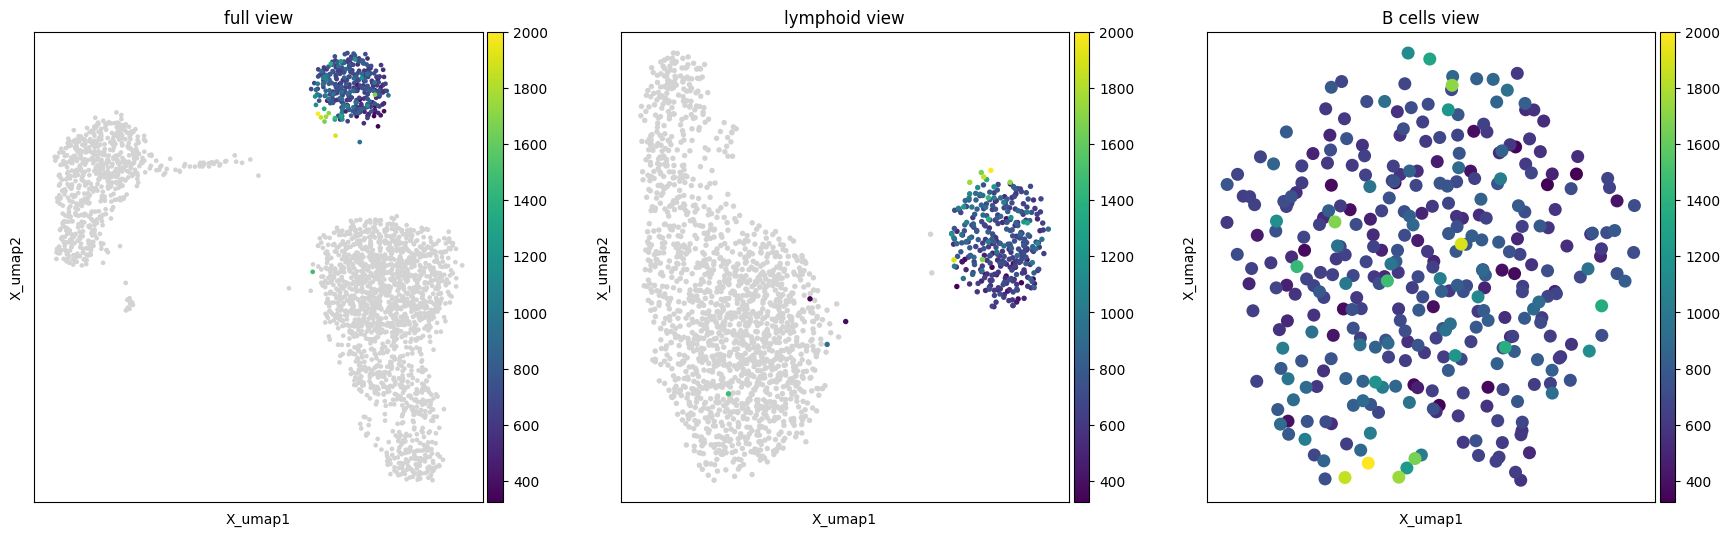

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


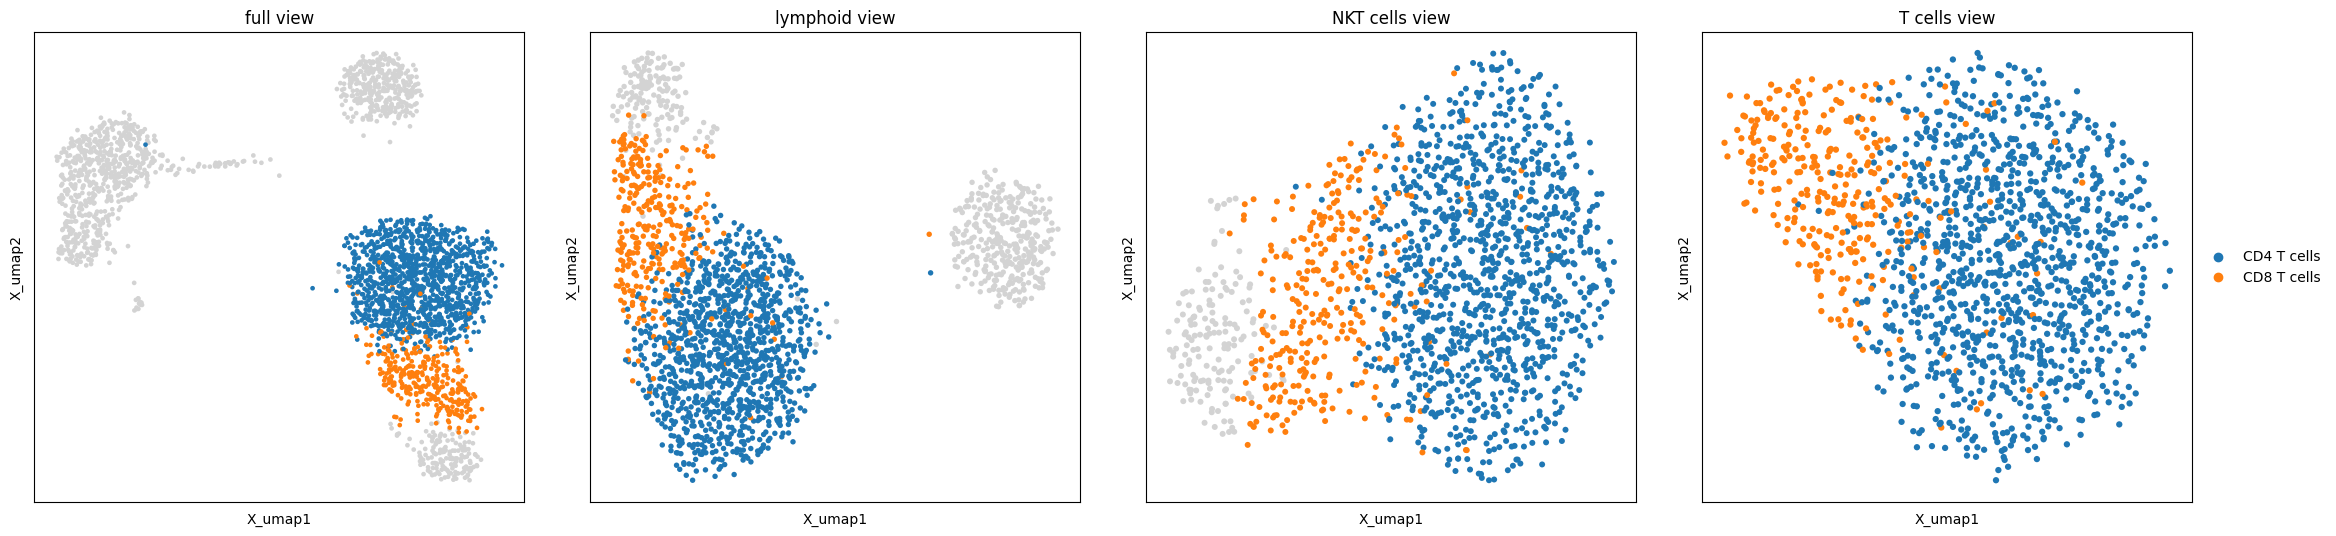

In [260]:
## Visualize nested embeddings
mva.pl.multiview_embedding(mvatlas, 'B cells', color= 'n_genes', legend_loc='right margin',fig_height=6)
mva.pl.multiview_embedding(mvatlas, 'T cells', color= 'louvain', legend_loc='right margin',fig_height=6)




## Fetal-immune dataset

In [118]:
import os
import multi_view_atlas as mva
datadir = '/nfs/team205/ed6/data/Fetal_immune/cellxgene_h5ad_files/scRNA_data/'
h5ad_files = [f for f in os.listdir(datadir) if f.endswith('embedding.h5ad')]

In [6]:
view_hierarchy = {
    'HSC_IMMUNE':{
        'HSC_PROGENITORS':None,
        'LYMPHOID':{
            'NKT':None
        },
        'MYELOID_V2':None,
        'MEM_PROGENITORS':None
    },
    'STROMA':None
}

In [7]:
adata_full = sc.read_h5ad(os.path.join(datadir, 'PAN.A01.v01.raw_count.20210429.PFI.embedding.h5ad'), backed=True)

AnnData object with n_obs × n_vars = 911873 × 33538 backed at '/nfs/team205/ed6/data/Fetal_immune/cellxgene_h5ad_files/scRNA_data/PAN.A01.v01.raw_count.20210429.PFI.embedding.h5ad'
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'view_color'
    var: 'GeneID', 'GeneName', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'scvi_model_var'
    uns: 'leiden', 'scvi', 'umap', 'view_hierarchy', 'view_color_colors'
    obsm: 'X_scvi', 'X_umap', 'view_assign'
    obsp: 'scvi_connectivities', 'scvi_distances'

In [8]:
from anndata import AnnData
adata_dict = {}
adata_dict['full'] = adata_full
for v in mva.utils.get_views_from_structure(view_hierarchy):
    vdata = sc.read_h5ad(os.path.join(datadir, f'PAN.A01.v01.raw_count.20210429.{v}.embedding.h5ad'), backed=True)
    # adata_dict[v] = AnnData(obs=vdata.obs, obsm=vdata.obsm)
    adata_dict[v] = vdata


In [9]:
import mudata
mdata = mudata.MuData(adata_dict)
mdata['full'].uns['view_hierarchy'] = view_hierarchy

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/mudata/_core/mudata.py:449: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/mudata/_core/mudata.py:569: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/mudata/_core/mudata.py:569: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colnam

In [119]:
mvatlas = mva.tl.MultiViewAtlas(mdata, transition_rule='X_scvi')

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


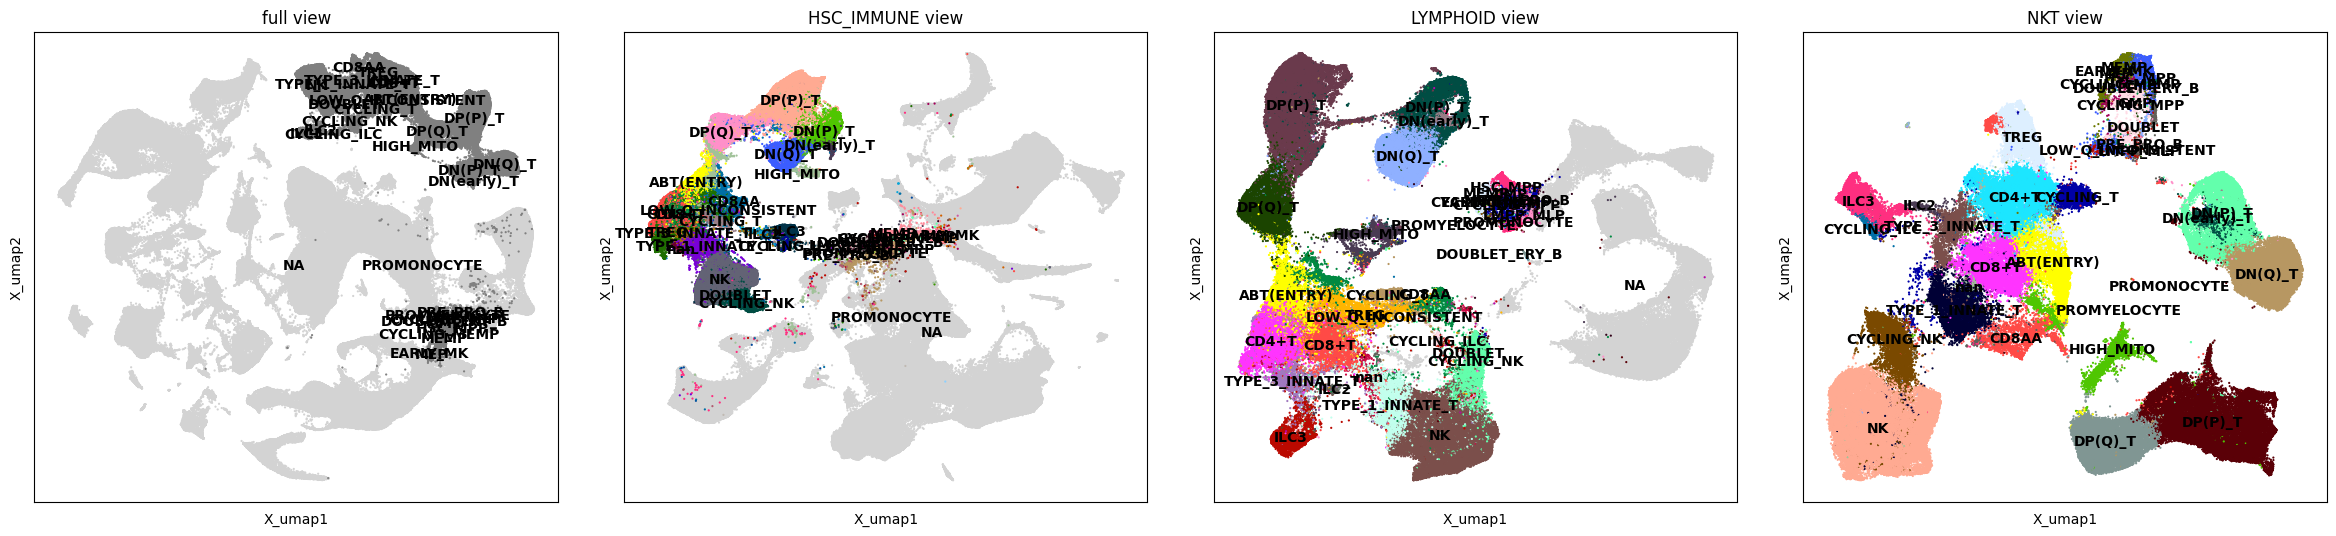

In [86]:
import multi_view_atlas as mva
mva.pl.multiview_embedding(mvatlas.mdata, view='NKT', color='anno_lvl_2_final_clean', size=10)